In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom
from smooth import Smoother, Memory, compute_diffs

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
PIXELS_PER_METER = 420 / 3.7 # approximately

In [8]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [9]:
test_images = [lanelines.open_image(f, convert_to_rgb=True) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [10]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

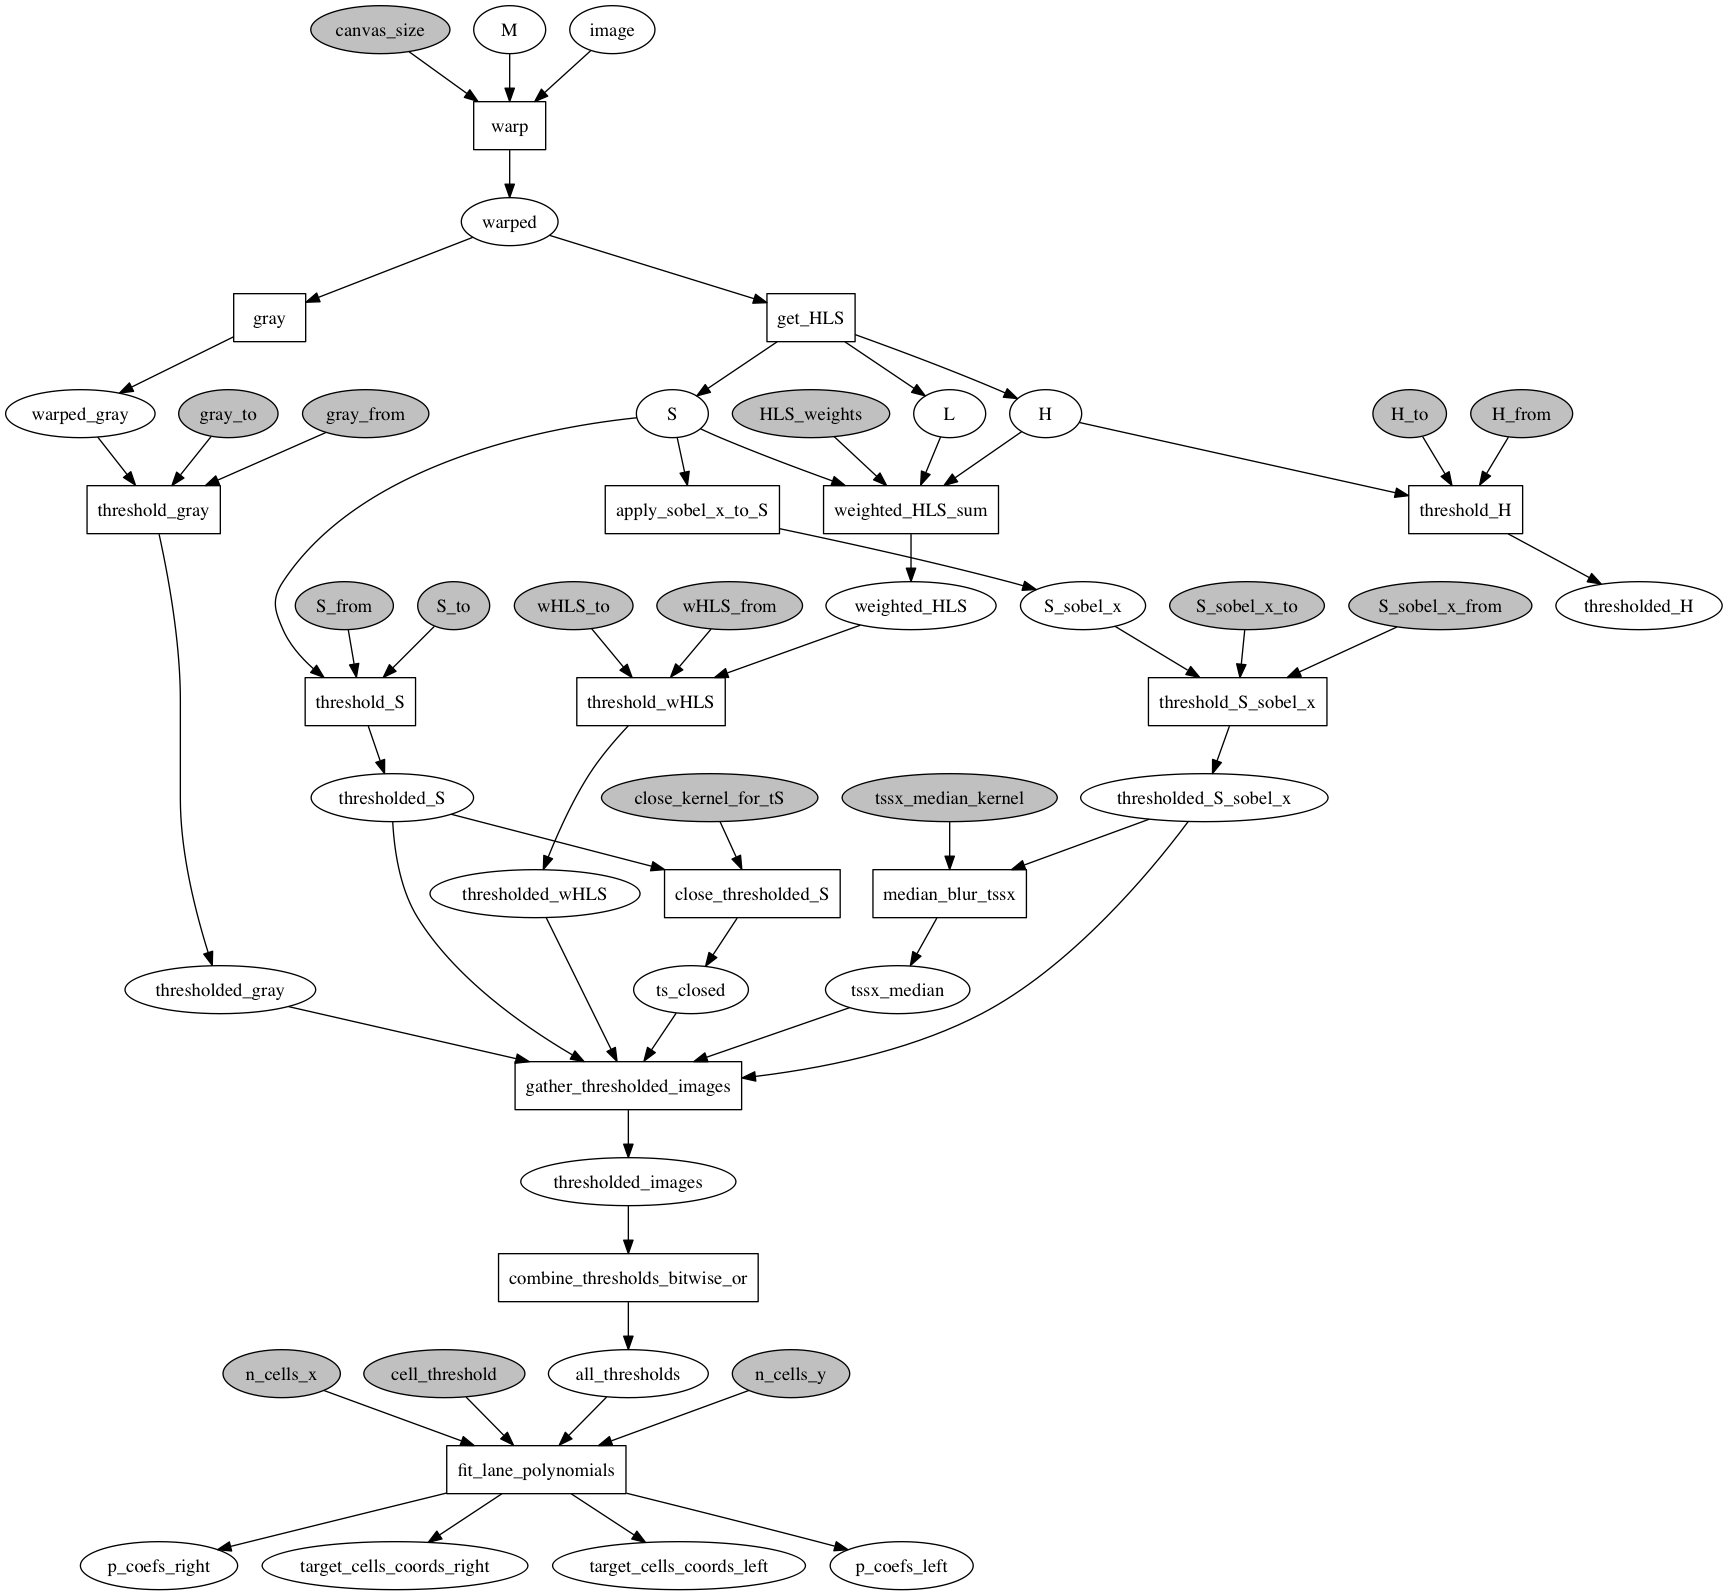

In [11]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

In [39]:
def create_processing_func_curvature(cg, cg_params, M, M_inv, memory_size=3, inf_curv_threshold=2000):

    runner = CompGraphRunner(cg, frozen_tokens=cg_params)

    tokens = ('p_coefs_left', 'p_coefs_right')
    thresholds = {
        'p_coefs_left': np.array([0.8e-4, 0.1, 80.]),
        'p_coefs_right': np.array([0.8e-4, 0.1, 80.])
    }
    
    last_y = cg_params['canvas_size'][1]
    pixels_per_meter = 113.5

    smoother = Smoother(runner, M, tokens, thresholds)
    curvature_mem = Memory(size=memory_size)

    def process(im):

        coefs = smoother(im)
        
        rendered_im = lanelines.render_lane(
            im, runner['warped'], coefs['p_coefs_left'], coefs['p_coefs_right'], M_inv
        )
        
        c1 = lanelines.curvature_poly2(coefs['p_coefs_left'], last_y)
        c2 = lanelines.curvature_poly2(coefs['p_coefs_right'], last_y)
        current_c =  (0.5 * (c1 + c2)) / pixels_per_meter
        
        if current_c > inf_curv_threshold:
            current_c = inf_curv_threshold
        
        if curvature_mem.is_empty():
            curvature_mem.insert(current_c)
            return rendered_im, current_c, current_c
        
        curvature = 0.5 * (curvature_mem.mean() + current_c)
        curvature_mem.insert(curvature)
        
        #print('{:.3f}\t{:.3f}'.format(current_c, curvature))
        
        return rendered_im, curvature, current_c

    return process

In [23]:

def lane_center(poly_x_left, poly_x_right, last_n=15):
    return poly_x_left[-last_n:] + (poly_x_right[-last_n:] - poly_x_left[-last_n:])

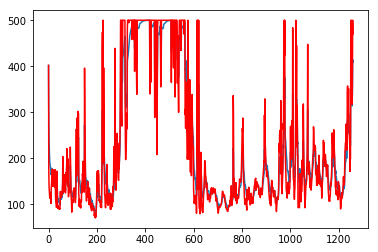

In [42]:
proc_func = create_processing_func_curvature(cg, cg_params, M, Minv, memory_size=10, inf_curv_threshold=500)
video_rd = imageio.get_reader('project_video.mp4')

curvatures_smoothed = []
curvatures_singleim = []

#for i in range(500):
for i in range(len(video_rd)):
    frame = video_rd.get_data(i)
    rendered_im, curv_smoothed, curv_singleim = proc_func(frame)
    
    curvatures_smoothed.append(curv_smoothed)
    curvatures_singleim.append(curv_singleim)
    
plt.plot(curvatures_smoothed)
plt.plot(curvatures_singleim, color='r')

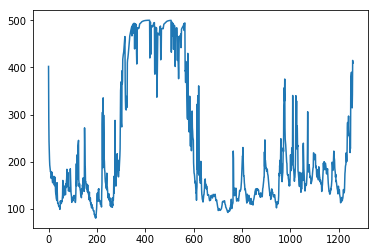

In [43]:
plt.plot(curvatures_smoothed)

In [27]:
1500 / 113.5

13.215859030837004

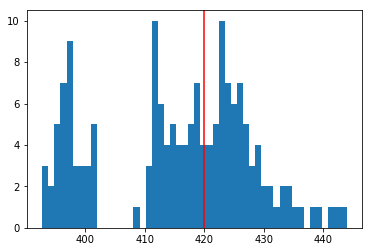

In [16]:
diffs_list = []

for im in test_images_undist:
    
    runner.run(image=im, M=M, Minv=Minv)
    
    poly_y, poly_x_left, poly_x_right = lanelines.get_lane_polynomials_points( runner['warped'], runner['p_coefs_left'], runner['p_coefs_right'] )
    
    diffs = lane_center(poly_x_left, poly_x_right, last_n=20)
    diffs_list.append(diffs)
    
all_diffs = np.concatenate(diffs_list)

_ = plt.hist(all_diffs, bins=50)
plt.axvline(420, color='r')

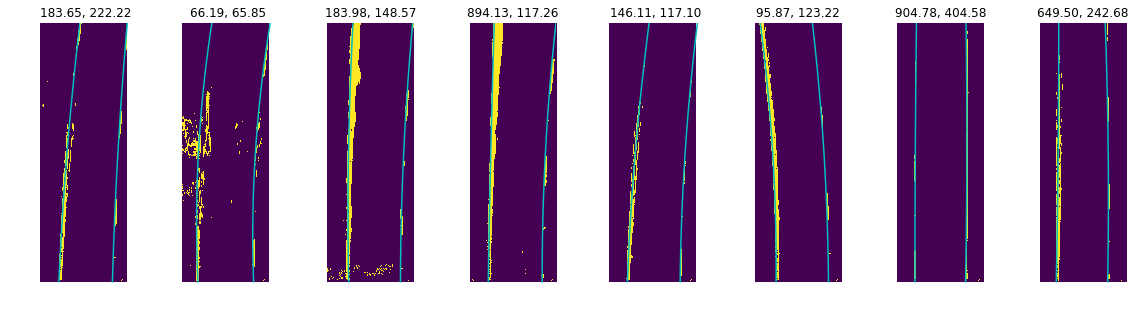

In [17]:
last_y = CANVAS_SZ[1]

plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')
    
    poly_y, poly_x_left, poly_x_right = lanelines.get_lane_polynomials_points( runner['warped'], runner['p_coefs_left'], runner['p_coefs_right'] )
    
    plt.plot(poly_x_left, poly_y, color='c')
    plt.plot(poly_x_right, poly_y, color='c')
    
    curv_left = lanelines.curvature_poly2(runner['p_coefs_left'], last_y)
    curv_right = lanelines.curvature_poly2(runner['p_coefs_right'], last_y)
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left / PIXELS_PER_METER, curv_right / PIXELS_PER_METER))